uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

pyro.set_rng_seed(0)
torch.manual_seed(0)
np.random.seed(0)

captcha_folder = 'generated_captchas'
captchaHeight = 24
captchaWidth = 60
captchaMarginX = 0
captchaMarginY = 0
batch_size = 1

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 5000 if not smoke_test else 100 # number of captchas generated for training 

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 1700
text 82 captcha shape (24, 60) noise 0.9003077649970919
text 59 captcha shape (24, 60) noise 0.727964419299247
text 15 captcha shape (24, 60) noise 0.6501656276799302
text 41 captcha shape (24, 60) noise 0.7154826518984315
text 32 captcha shape (24, 60) noise 0.4724626182787427
text 14 captcha shape (24, 60) noise 0.03616390800734124
text 42 captcha shape (24, 60) noise 0.11314963153752981
text 93 captcha shape (24, 60) noise 0.9858799572401995
text 94 captcha shape (24, 60) noise 0.5099693123963349
text 87 captcha shape (24, 60) noise 0.4360361396113115
text 44 captcha shape (24, 60) noise 0.5935795083117388
number of samples in group 1653
text 048 captcha shape (24, 60) noise 0.8375334144945471
text 156 captcha shape (24, 60) noise 0.7886520360717119
text 185 captcha shape (24, 60) noise 0.64102177901862
text 899 captcha shape (24, 60) noise 0.08704548784132556
text 294 captcha shape (24, 60) noise 0.38599793670122656

text 82 noise 0.9003077649970919


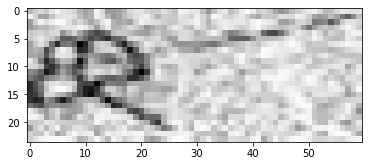

text 59 noise 0.727964419299247


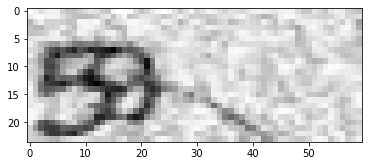

text 15 noise 0.6501656276799302


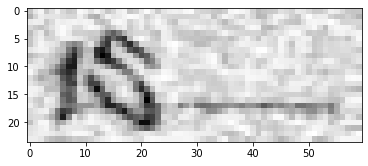

text 41 noise 0.7154826518984315


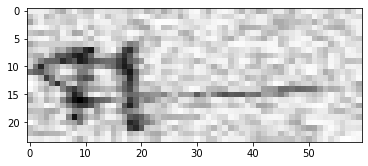

text 32 noise 0.4724626182787427


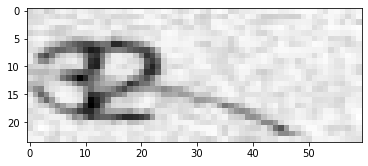

text 048 noise 0.8375334144945471


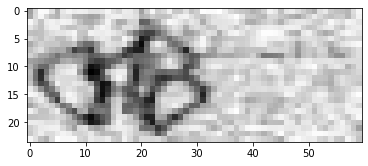

text 156 noise 0.7886520360717119


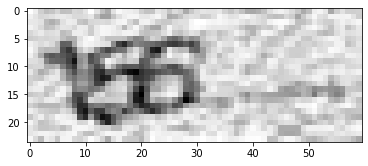

text 185 noise 0.64102177901862


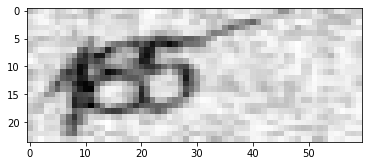

text 899 noise 0.08704548784132556


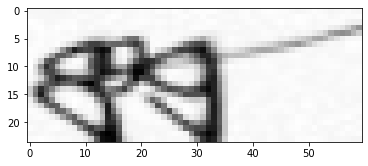

text 294 noise 0.38599793670122656


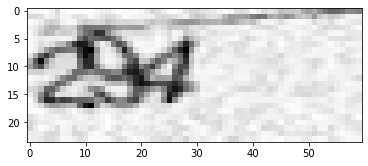

text 2129 noise 0.82354150392381


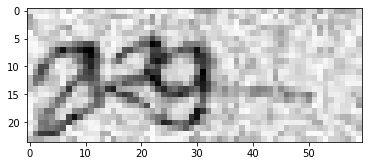

text 5422 noise 0.340207610354462


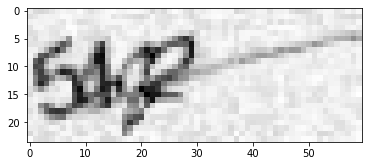

text 8961 noise 0.22890856533597448


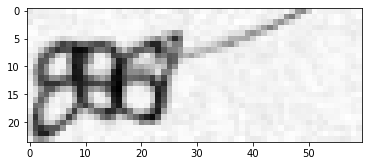

text 6024 noise 0.31343688444884715


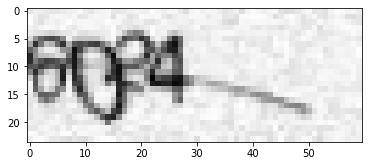

text 2181 noise 0.03507273901626142


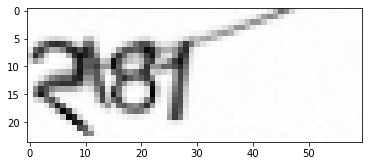

In [3]:
for lst in captcha_generated:
    for i in range(5):
        if len(lst) > 0:
            print("text", lst[i][0], "noise", lst[i][2])
            plt.imshow(255-lst[i][1], cmap="Greys")
            plt.show()
        
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# for lst in captcha_generated:
#     for i in range(5):
#         if len(lst) > 0:
#             print("text", lst[i][0], "noise", lst[i][4], "blend_alpha", lst[i][5])
#             plt.imshow(255-lst[i][1], cmap="Greys")
#             plt.show()
#             #print(255-lst[0][1])
#             plt.imshow(255-lst[i][2], cmap="Greys")
#             plt.show()
#             #print(255 - lst[0][2])
#             #plt.imshow(np.round((255-lst[0][2]) * blend_alpha + (255-lst[0][1]) * (1- blend_alpha)), cmap="Greys")
#             plt.imshow(255-lst[i][3], cmap="Greys")
#             plt.show()
#             #print(np.minimum(255, (255-lst[0][2] + 255-lst[0][1])))

In [4]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [5]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [6]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        img = sample_batched[1][0]
        #print("img", img.shape)
        if use_cuda:
            img = img.cuda()
        IMG = {"obs" : img.float()}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [7]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def _map_to_noise_range(input):
    noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
    input = torch.distributions.transform_to(noise_constraint)(input)
    return input


def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1][0]

        if use_cuda:
            img = img.cuda()
        #print("test", img.shape)
        IMG = {"obs" : img.float()}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + MIN_N
            noise = _map_to_noise_range(marginal_noise())
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)

In [8]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [9]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_noise_differences,
    }
    print(save_dict)
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

In [10]:
import guide_nn_obs_v2 as guide
import model

In [11]:
class ObsEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, img):
        #print(img.shape)
        img = img.unsqueeze(0).unsqueeze(0).float()

        img = self.pool(F.relu(self.conv1(img)))
        #print(img.shape)
        img = self.pool(F.relu(self.conv2(img)))
        #print(img.shape)

        img = self.pool(F.relu(self.conv3(img)))
        #print(img.shape)
        
        return img
obs_embedding = ObsEmbedding().cuda()

In [12]:
def wrapped_guide(observations):
    pyro.module("obs_embedding", obs_embedding)
    emb_obs = obs_embedding(observations['obs'])
    return guide.model({'obs':emb_obs})
    

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n0 = count_parameters(obs_embedding)
n1 = count_parameters(guide._nn_model_char_char_i)
n2 = count_parameters(guide._nn_rhs)
n3 = count_parameters(guide._nn_model_noise)
n4 = count_parameters(guide._nn_model_num_char)
n5 = count_parameters(guide._nn_text)
print(n0, n1, n2, n3, n4, n5, "total:", n0+n1+n2+n3+n4+n5)

222080 3494474 525824 1708034 1182723 591360 total: 7724495


In [14]:
optimiser = pyro.optim.Adam({'lr': 2e-4})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_guide3.json")


Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_nn_obs_v2.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  num_char = P.sample('num_char', PD.Categorical(TN.LogSoftmax()(T.reshape(
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_nn_obs_v2.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  char_i = P.sample(f'char_{i}', PD.Categorical(TN.LogSoftmax()(T.

loss at epoch 1 is 4.968752494494632; Epoch takes 1982 seconds
loss at epoch 2 is 2.312255669017888; Epoch takes 2265 seconds
loss at epoch 3 is 1.3860070461196; Epoch takes 2263 seconds
loss at epoch 4 is 0.7248716296810154; Epoch takes 2255 seconds
loss at epoch 5 is 0.2864184769610746; Epoch takes 2257 seconds
use_train = True AVG Noise Difference: 0.04480541634324501 Total correct: 2018 accuracy:2018/5000= 0.4036 char_accuracy:10702/14947= 0.7159965210410115
use_train = False AVG Noise Difference: 0.04487043212971987 Total correct: 402 accuracy:402/1000= 0.402 char_accuracy:2161/3005= 0.7191347753743761
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.227 | Actual Noise: 0.122 | Predicted Text: 66 | Actual Text: 96 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.776 | Actual Noise: 0.781 | Predicted Text: 1379 | Actual Text: 1379 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.465 | Actual Noise: 0.438 | Predicted Text: 721 | Actual Text: 721 | Correc

loss at epoch 21 is -1.0283408601519792; Epoch takes 1816 seconds
loss at epoch 22 is -1.0457096200073976; Epoch takes 1816 seconds
loss at epoch 23 is -1.0551010040046545; Epoch takes 1841 seconds
loss at epoch 24 is -1.0659467592485175; Epoch takes 1957 seconds
loss at epoch 25 is -1.0908336448979155; Epoch takes 1982 seconds
use_train = True AVG Noise Difference: 0.033691405978837415 Total correct: 3903 accuracy:3903/5000= 0.7806 char_accuracy:13708/14947= 0.917107111795009
use_train = False AVG Noise Difference: 0.034133398905883905 Total correct: 784 accuracy:784/1000= 0.784 char_accuracy:2766/3005= 0.9204658901830283
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.217 | Actual Noise: 0.151 | Predicted Text: 8104 | Actual Text: 8104 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.18 | Actual Noise: 0.012 | Predicted Text: 1133 | Actual Text: 1133 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.532 | Actual Noise: 0.515 | Predicted Text: 5078 | Actua

loss at epoch 41 is -1.2230021188828926; Epoch takes 1819 seconds
loss at epoch 42 is -1.2214925629274862; Epoch takes 1815 seconds
loss at epoch 43 is -1.2380201905596793; Epoch takes 1818 seconds
loss at epoch 44 is -1.24147749541995; Epoch takes 1813 seconds
loss at epoch 45 is -1.2443980375175445; Epoch takes 1824 seconds
use_train = True AVG Noise Difference: 0.03218995808850605 Total correct: 4070 accuracy:4070/5000= 0.814 char_accuracy:13921/14947= 0.9313574630360607
use_train = False AVG Noise Difference: 0.03206315621685067 Total correct: 846 accuracy:846/1000= 0.846 char_accuracy:2791/2967= 0.9406808223795079
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.62 | Actual Noise: 0.62 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.23 | Actual Noise: 0.14 | Predicted Text: 43 | Actual Text: 43 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.368 | Actual Noise: 0.368 | Predicted Text: 9063 | Actual Text: 9063 | 

loss at epoch 61 is -1.3280156516719652; Epoch takes 1846 seconds
loss at epoch 62 is -1.330947562663477; Epoch takes 1835 seconds
loss at epoch 63 is -1.329335611042066; Epoch takes 1834 seconds
loss at epoch 64 is -1.330642850770562; Epoch takes 1832 seconds
loss at epoch 65 is -1.330493242951536; Epoch takes 1834 seconds
use_train = True AVG Noise Difference: 0.027721240072290522 Total correct: 4085 accuracy:4085/5000= 0.817 char_accuracy:13929/14947= 0.9318926874958186
use_train = False AVG Noise Difference: 0.02724961714410141 Total correct: 830 accuracy:830/1000= 0.83 char_accuracy:2868/3060= 0.9372549019607843
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.731 | Actual Noise: 0.748 | Predicted Text: 36 | Actual Text: 36 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.215 | Actual Noise: 0.177 | Predicted Text: 9979 | Actual Text: 9979 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.515 | Actual Noise: 0.502 | Predicted Text: 770 | Actual Text: 77

loss at epoch 81 is -1.3800620768974026; Epoch takes 1840 seconds
loss at epoch 82 is -1.3821851945665262; Epoch takes 1848 seconds
loss at epoch 83 is -1.3872883651543273; Epoch takes 1872 seconds
loss at epoch 84 is -1.3944953888138223; Epoch takes 1948 seconds
loss at epoch 85 is -1.3938116794210238; Epoch takes 1911 seconds
use_train = True AVG Noise Difference: 0.023303422301176383 Total correct: 4200 accuracy:4200/5000= 0.84 char_accuracy:14062/14947= 0.9407907941392921
use_train = False AVG Noise Difference: 0.023057198867212473 Total correct: 833 accuracy:833/1000= 0.833 char_accuracy:2849/3032= 0.9396437994722955
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.578 | Actual Noise: 0.57 | Predicted Text: 758 | Actual Text: 758 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.862 | Actual Noise: 0.881 | Predicted Text: 808 | Actual Text: 808 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.844 | Actual Noise: 0.871 | Predicted Text: 15 | Actual Text:

loss at epoch 101 is -1.4165917504283225; Epoch takes 1830 seconds
loss at epoch 102 is -1.416024683763447; Epoch takes 1828 seconds
loss at epoch 103 is -1.4290354831917296; Epoch takes 1875 seconds
loss at epoch 104 is -1.42176416741032; Epoch takes 1878 seconds
loss at epoch 105 is -1.4035292843615559; Epoch takes 1875 seconds
use_train = True AVG Noise Difference: 0.02549420053353621 Total correct: 4165 accuracy:4165/5000= 0.833 char_accuracy:14002/14947= 0.9367766106911086
use_train = False AVG Noise Difference: 0.02575515406840347 Total correct: 838 accuracy:838/1000= 0.838 char_accuracy:2846/3028= 0.939894319682959
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.251 | Actual Noise: 0.252 | Predicted Text: 044 | Actual Text: 044 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.826 | Actual Noise: 0.807 | Predicted Text: 856 | Actual Text: 856 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.699 | Actual Noise: 0.705 | Predicted Text: 04 | Actual Text

loss at epoch 121 is -1.4376757922012287; Epoch takes 1831 seconds
loss at epoch 122 is -1.4088993812108483; Epoch takes 1828 seconds
loss at epoch 123 is -1.4441963800691182; Epoch takes 1886 seconds
loss at epoch 124 is -1.4505757359922238; Epoch takes 1924 seconds
loss at epoch 125 is -1.460599258154848; Epoch takes 1904 seconds
use_train = True AVG Noise Difference: 0.022871226198576976 Total correct: 4202 accuracy:4202/5000= 0.8404 char_accuracy:14078/14947= 0.9418612430588078
use_train = False AVG Noise Difference: 0.023136229592136775 Total correct: 842 accuracy:842/1000= 0.842 char_accuracy:2807/2982= 0.9413145539906104
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.86 | Actual Noise: 0.847 | Predicted Text: 842 | Actual Text: 642 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.883 | Actual Noise: 0.903 | Predicted Text: 1944 | Actual Text: 1943 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.239 | Actual Noise: 0.217 | Predicted Text: 6441 | Ac

loss at epoch 141 is -1.4704896387356838; Epoch takes 1826 seconds
loss at epoch 142 is -1.4686140861978443; Epoch takes 1837 seconds
loss at epoch 143 is -1.4835409169089713; Epoch takes 1840 seconds
loss at epoch 144 is -1.4809793525539527; Epoch takes 1835 seconds
loss at epoch 145 is -1.2664886935968425; Epoch takes 1832 seconds
use_train = True AVG Noise Difference: 0.02592269662258214 Total correct: 4264 accuracy:4264/5000= 0.8528 char_accuracy:14142/14947= 0.9461430387368702
use_train = False AVG Noise Difference: 0.02799376618281566 Total correct: 820 accuracy:820/1000= 0.82 char_accuracy:2775/2976= 0.9324596774193549
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.175 | Actual Noise: 0.147 | Predicted Text: 26 | Actual Text: 26 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.849 | Actual Noise: 0.846 | Predicted Text: 56 | Actual Text: 57 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.708 | Actual Noise: 0.721 | Predicted Text: 662 | Actual Tex

loss at epoch 161 is -1.488990916399059; Epoch takes 1833 seconds
loss at epoch 162 is -1.4861663939070877; Epoch takes 1890 seconds
loss at epoch 163 is -1.427346365013446; Epoch takes 1872 seconds
loss at epoch 164 is -1.5081651726512608; Epoch takes 1862 seconds
loss at epoch 165 is -1.4626473892550549; Epoch takes 1841 seconds
use_train = True AVG Noise Difference: 0.021125940561895387 Total correct: 4245 accuracy:4245/5000= 0.849 char_accuracy:14122/14947= 0.9448049775874757
use_train = False AVG Noise Difference: 0.020909888523381246 Total correct: 845 accuracy:845/1000= 0.845 char_accuracy:2860/3025= 0.9454545454545454
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.629 | Actual Noise: 0.625 | Predicted Text: 935 | Actual Text: 935 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.762 | Actual Noise: 0.78 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.139 | Actual Noise: 0.104 | Predicted Text: 4067 | Actual T

loss at epoch 181 is 0.678082211329926; Epoch takes 1834 seconds
loss at epoch 182 is 0.18112383718243485; Epoch takes 1831 seconds
loss at epoch 183 is -0.09777840585815813; Epoch takes 1831 seconds
loss at epoch 184 is -0.26092319174475326; Epoch takes 1830 seconds
loss at epoch 185 is -0.14199840394670346; Epoch takes 1821 seconds
use_train = True AVG Noise Difference: 0.021552809742204464 Total correct: 2146 accuracy:2146/5000= 0.4292 char_accuracy:11004/14947= 0.736201244396869
use_train = False AVG Noise Difference: 0.02112044936613755 Total correct: 448 accuracy:448/1000= 0.448 char_accuracy:2229/2991= 0.7452357071213641
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.191 | Actual Noise: 0.163 | Predicted Text: 529 | Actual Text: 523 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.204 | Actual Noise: 0.198 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.794 | Actual Noise: 0.785 | Predicted Text: 9847 | Actua

KeyboardInterrupt: 

# 